### **Sound of Birds Classification - EDA & Data Processing**

**1. Import data**

In [1]:
import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
import json

pd.set_option('display.max_columns', None)

data_path = r'D:\UCLA\Data projects\Voice of Birds\Voice of Birds'

In [3]:
df = pd.read_csv('Birds Voice.csv')
df['recording_length'] = pd.to_datetime(df['recording_length'], format= '%M:%S').dt.time
df.head(1)

,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,00:00:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download


**2. Data Exploratory Analysis**

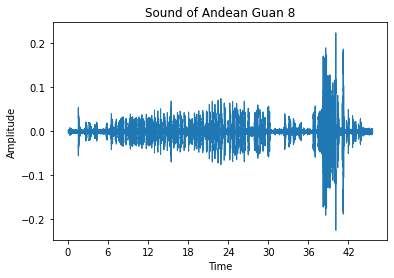

In [5]:
signal, sr = librosa.load("Andean Guan8.mp3")
librosa.display.waveshow(signal, sr = sr)

plt.title('Sound of Andean Guan 8')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

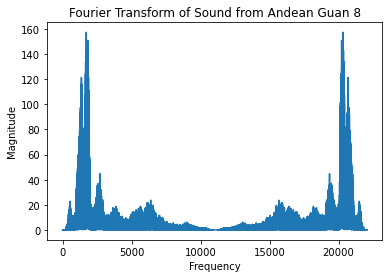

In [6]:
"""Fourier Transform"""

fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

plt.plot(frequency, magnitude)
plt.title('Fourier Transform of Sound from Andean Guan 8')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

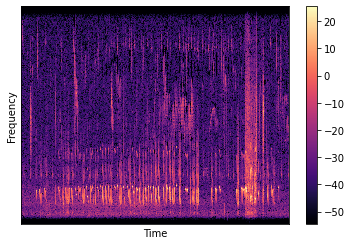

In [7]:
"""Short-time Fourier Transform"""

n_fft = 2048 # no. of sample per window
hop_length = 512 # slide per interval toward the right

stft = librosa.core.stft(signal, hop_length= hop_length, n_fft = n_fft)

spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram) # use this method to visualize result better

# Visualize spectrogram data

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

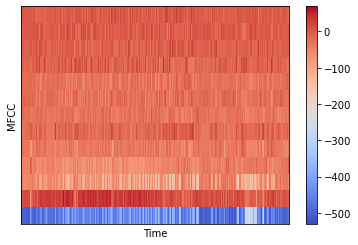

In [8]:
"""MFCC"""

mfcc = librosa.feature.mfcc(y=signal, n_fft = n_fft, hop_length = hop_length, n_mfcc=13) # n_mfcc = 13 is commonly used in audio analysis

librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()


**3. Data Engineering - Prepare Dataset for ML Model**

In [10]:
def prepare_dataset(folder_path, sr, segment_length):
    
    data = {
        "mapping":[],"mfcc":[],"labels":[]
    }

    data['mapping'] = [bird.split("_")[0] for bird in os.listdir(data_path) if os.path.isdir(os.path.join(data_path,bird))]

    for i, (root, dirs, files) in enumerate(os.walk(folder_path)):
        if root is not folder_path:
            for f in files:
                file_path = os.path.join(root, f)
                signal, sr = librosa.load(file_path)

                audio = AudioSegment.from_file(file_path)
                duration_seconds = len(audio)/1000
                num_segments = int(duration_seconds//segment_length)

                if num_segments > 0:
                    for s in range(num_segments-1):
                        start_sample = sr * s * segment_length
                        finish_sample = start_sample + sr * segment_length
                        mfcc = librosa.feature.mfcc(y=signal[start_sample: finish_sample], n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
                        mfcc = mfcc.T

                        data["mfcc"].append(mfcc.tolist())
                        data['labels'].append(i-1)
                        # print("{}, segment:{}".format(file_path, s+1))
    
    return data

data_path = r'D:\UCLA\Data projects\Voice of Birds\Voice of Birds'

output = prepare_dataset(data_path, 22050,15)

with open("output15.json","w") as fp:
    json.dump(output, fp, indent = 4)